We propose a method for finding wave functions in an infinitely deep well by displacing the wave function from the forbidden zone by imposing a fee

## Imports


In [1]:
# Imports
import torch, time
from torch import nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## General parameters

Мы определяем различные параметры и гиперпараметры.

In [2]:
# Hardware (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 20 # Nodes in the hidden layer

# Network parameters.
seed = 1                                       # Seed of the random number generator
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True)
B1 = torch.rand(Nhid, requires_grad=True) * 2. - 1.    
W2 = torch.rand(Nhid, Nhid, requires_grad=True)      
B2 = torch.rand(Nhid, requires_grad=True) * 2. - 1.    
W3 = torch.rand(Nout, Nhid, requires_grad=True)    

# Training hyperparameters
epochs = 40000
lr = 1e-4  # Learning rate

# Mesh parameters
Nx = 1000                    # Mesh division
train_a = -3                      # Mesh lower limit
train_b = 3                        # Mesh upper limit
h = (train_b - train_a)/(Nx - 1)  # Mesh parameter "h"
wi = torch.empty(Nx, 1).fill_(h).to(device)     # Integration weights for this mesh. 
                                    # We are using trapezoids with zero boundary conditions
Q_train = torch.linspace(train_a, train_b, Nx, requires_grad=True, device=device)  

a = -1
b = 1


Q1 = Q_train.detach().cpu().apply_(lambda x: 1 if -1<x<1 else 0)
target = np.sqrt(2/(b-a))*torch.cos(np.pi/(b - a)*Q_train)*Q1.to(device)


## The neural network

In [3]:
class HarmonicNNQS(nn.Module):
    def __init__(self, W1, B1, W2, B2, W3):
        super().__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Tanh()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nhid, 
                             bias=True)  # shape = (Nout, Nhid)
        self.actfun2 = nn.Tanh()        # activation function
        self.lc3 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=True)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B1)
            self.lc2.bias = nn.Parameter(B2)
            self.lc2.weight = nn.Parameter(W2)
            self.lc3.weight = nn.Parameter(W3)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc3(self.actfun2(self.lc2(self.actfun(self.lc1(x)))))
        return o

In [4]:
net = HarmonicNNQS(W1, B1, W2, B2, W3).to(device)
print("NN architecture:\n", net)

NN architecture:
 HarmonicNNQS(
  (lc1): Linear(in_features=1, out_features=20, bias=True)
  (actfun): Tanh()
  (lc2): Linear(in_features=20, out_features=20, bias=True)
  (actfun2): Tanh()
  (lc3): Linear(in_features=20, out_features=1, bias=True)
)


In [5]:
optimizer = torch.optim.AdamW(params=net.parameters(), lr=lr)

## The loss function

Now we have to define the loss function, which in our case is the mathematical expectation of energy calculated using the Hamiltonian and our NNQS. This is
$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}}{\bra{\psi_\theta}\psi_\theta\rangle}. $$

This expression can be calculated as two integrals in the coordinate space:

$$\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}=\int_{-\infty}^{+\infty} \psi_\theta\hat{H}\psi_\theta dx$$

$$ \bra{\psi_\theta}\psi_\theta\rangle=\int_{-\infty}^{+\infty} \psi_\theta^2 dx$$

The first integral can be rewritten so that the second derivative does not appear. This will be useful when calculating the loss function. The "trick" is to integrate the kinetic term in parts and introduce that

$$ \lim_{x\to \pm\infty}\psi_\theta(x) = 0. $$

After this step, we can discretize the integrals according to our lattice:

$$ \bra{\psi_\theta}\hat{H}\ket{\psi_\theta}=\frac{1}{2}\int_{-\infty}^{+\infty}\bigg [\bigg (\frac{d\psi_\theta(x)}{dx}\bigg )^2\bigg ]dx \approx \frac{1}{2}\sum_{i=1}^{N_x} w_i \bigg[\bigg(\frac{d\psi_\theta(x_i)}{dx}\bigg)^2\bigg], $$

$$\bra{\psi_\theta}\psi_\theta\rangle\approx \sum_{i=1}^{N_x} w_i \psi_\theta^2(x_i)\equiv N.$$

In PyTorch, the loss function should be defined as an external function that returns (at least) the scalar loss value calculated using NNQS at a given epoch. Below is our implementation.

In [6]:
def loss_fn():  
    lambd = 10
    mu = 1
    psi = net(X)
    psi2 = net(X_det).pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = torch.tensordot(psi2, wi)                       
    K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
    Q2 = Q_train.detach().cpu().apply_(lambda x: 0 if -1<x<1 else 1).to(device)
    Q2 = torch.unsqueeze(Q2,1)
    U = lambd*torch.tensordot(psi2,Q2) / N
    regul = torch.tensordot(net.lc1.weight,net.lc1.weight) 
    + torch.tensordot(net.lc2.weight,net.lc2.weight) + torch.tensordot(net.lc3.weight,net.lc3.weight) #regularization
    L = U + K + mu*regul # Total energy
    
    
    return L, U, K, psi, psi / torch.sqrt(N) 

## Plotting

In [7]:
def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    x_cpu = x.detach().cpu().numpy()
    target_cpu = target.detach().cpu().numpy()
    # Overlap
    ax1.set_title('Normalized wave function')
    wf = psi_normalized.detach().cpu().numpy()
    if np.max(wf) < 0: wf = -wf
    ax1.set_ylim(-0.05, np.max(wf)*1.1)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x_cpu)
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x_cpu)
        ax1.lines[1].set_ydata(target_cpu)
    else:
        # This code will only run the first time the function is called
        ax1.plot(x_cpu, wf, label='$\psi_\mathrm{NNQS}$', color='b')
        ax1.plot(x_cpu, target_cpu, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend()
    
    # Wave function
    ax2.set_title('NNQS wave function')
    wf = psi.detach().cpu().numpy()
    if np.max(wf) < 0: wf = -wf 
    ax2.set_ylim(-0.05, np.max(wf)*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x_cpu)
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x_cpu, wf, 
                 label='$\psi_\mathrm{NNQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)*(np.pi*np.pi/8)][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$L$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)*(np.pi*np.pi/8), linestyle='--', label='$E_0$', color='b')
        ax3.legend()
        
    fig.canvas.draw()

## Training the network: ground state, $\ket{\psi_0}$

<IPython.core.display.Javascript object>


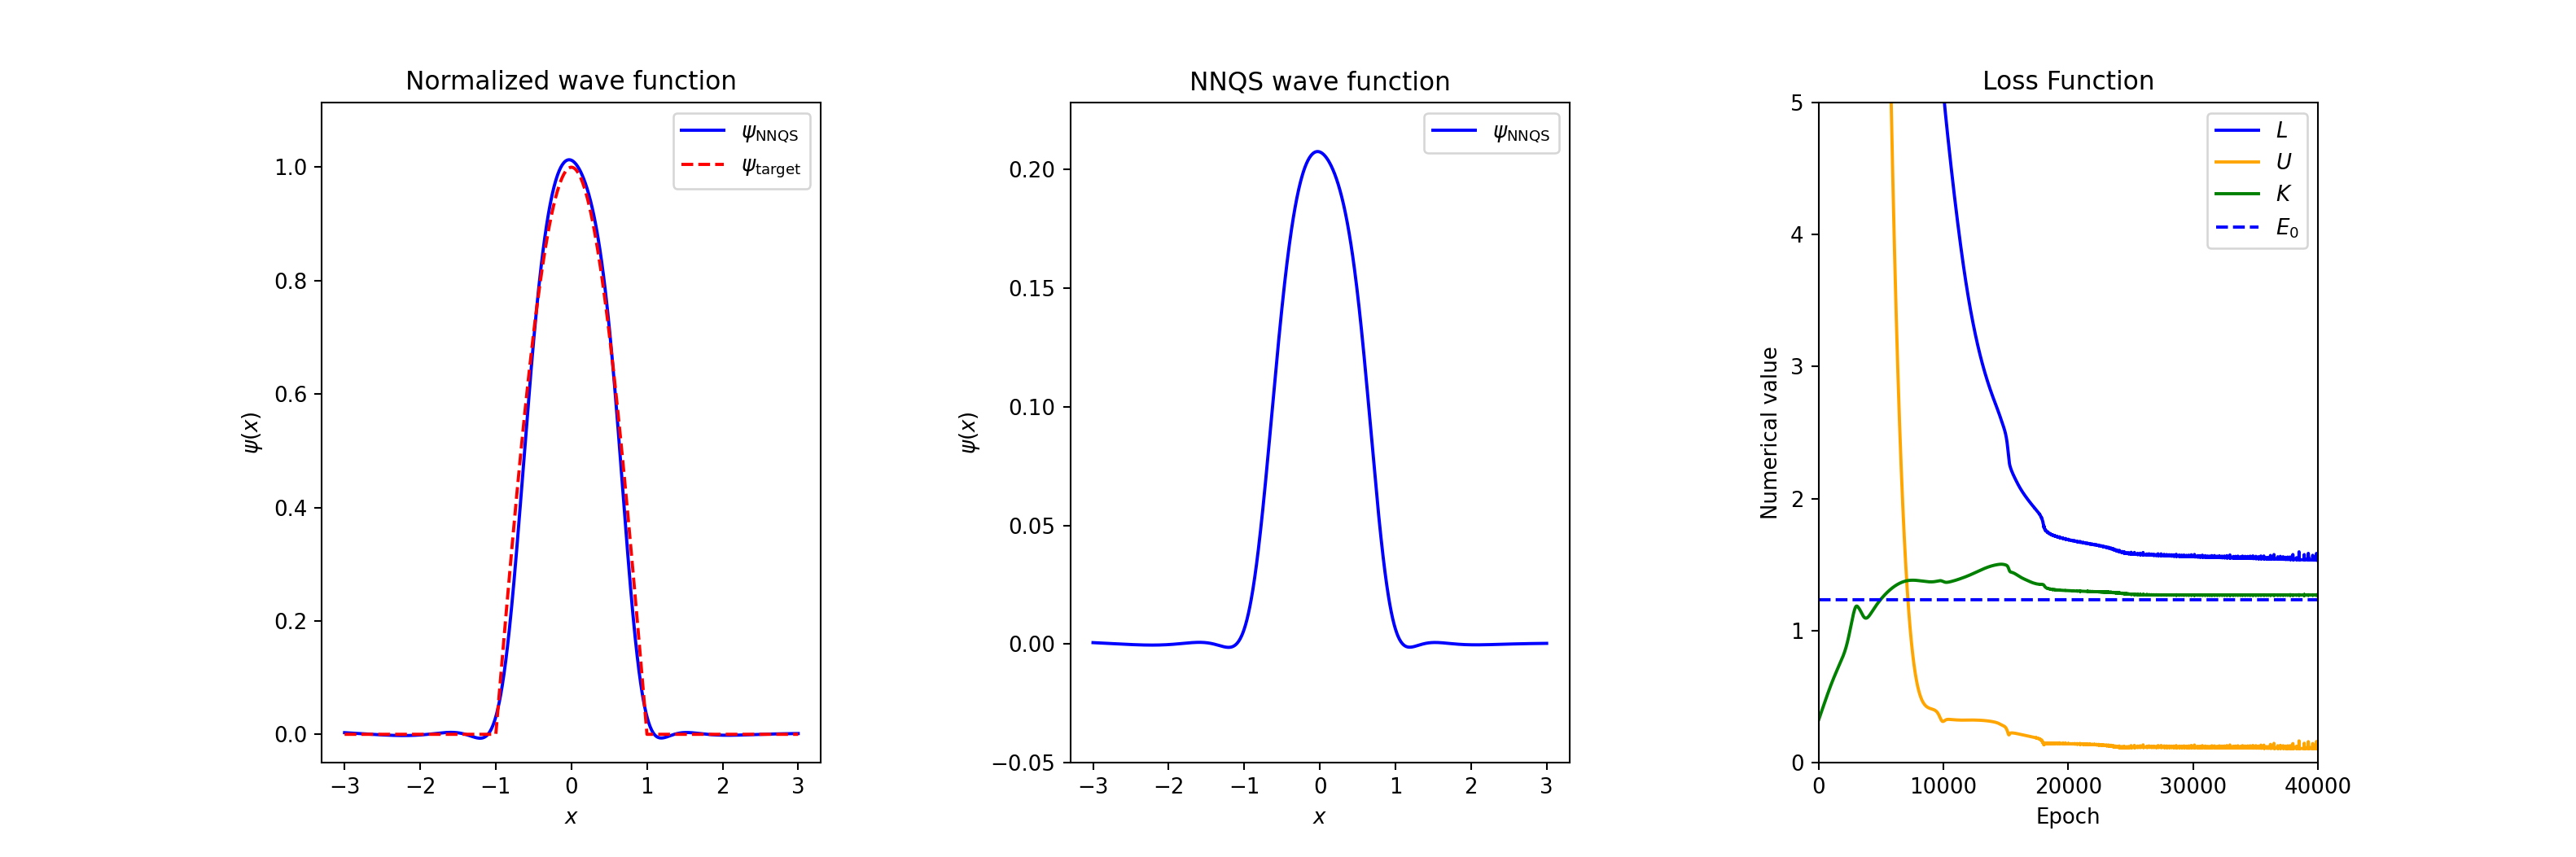

Training the NNQS...: 100%|█████████████████████████████████████████████████████| 40000/40000 [03:07<00:00, 213.66it/s]


In [8]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Numerical value")
ax3.set_ylim(0, 5)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1) # Training set
X_det = X.clone().detach() # Training set without gradients

# Training
loss0, U, K, psi, psi_normalized = loss_fn()
for i in tqdm(range(epochs), desc="Training the NNQS..."):    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss0.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation
    
    loss_accum.append(loss0.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)

E0, psi0 = loss_accum[-1], psi.clone().detach()

## Training the network: first excited state, $\ket{\psi_1}$

Now let's move on to the first excited state. The process is almost identical to the process of finding the ground state wave function, with the fundamental difference that now the Ritz method requires that

$$ \langle\psi_{0,\theta}|\psi_{1,\theta'}\rangle = 0, $$

where $\psi_{0,\theta}, \psi_{1,\theta'}$ are the wave functions of the paragraph of the ground and first excited states, respectively. An easy way to impose this condition is to make $\psi_1$antisymmetric (given that $\psi_0$ is symmetric),

$$ \psi_{1,\theta'}(x) \longleftarrow \psi_{1,\theta'}(x)-\psi_{1,\theta'}(-x) .$$

 

In [9]:
def loss_fn_prime(E0, psi0):  
    lambd = 100
    mu = 10
    X_det = X.clone().detach()
    psi = net1(X)-net1(-X) 
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = torch.tensordot(psi2, wi)                       
    K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
    Q2 = Q_train.detach().cpu().apply_(lambda x: 0 if -1<x<1 else 1).to(device)
    Q2 = torch.unsqueeze(Q2,1)
    U = lambd*torch.tensordot(psi2,Q2) / N
    regul = torch.tensordot(net.lc1.weight,net.lc1.weight) 
    + torch.tensordot(net.lc2.weight,net.lc2.weight) + torch.tensordot(net.lc3.weight,net.lc3.weight) #regularization
    L = U + K + mu*regul # Total energy
    
    return L, U, K, psi, psi / torch.sqrt(N) 

Now we are defining a new neural network that has exactly the same architecture as the one used for the ground state. We can do this by creating a new instance of our NNQS class. We also reset the parameters of the optimizer, redefining it.

In [10]:
net1 = HarmonicNNQS(W1, B1, W2, B2, W3).to(device)
optimizer = torch.optim.AdamW(params=net1.parameters(), lr=lr)

target = np.sqrt(2/(b-a))*torch.sin(2*np.pi/(b - a)*Q_train)*Q1.to(device)

We are defining a new plotting function,

In [11]:
def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    x_cpu = x.detach().cpu().numpy()
    target_cpu = target.detach().cpu().numpy()
    # Overlap
    ax1.set_title('Normalized wave function')
    wf = psi_normalized.detach().cpu().numpy()
    if net1(torch.tensor([[-2.]]).to(device)).item() < 0.: wf *= -1
    lim_inf, lim_sup = min(min(wf), min(target_cpu)), max(max(wf), max(target_cpu))
    ax1.set_ylim(lim_inf*1.1, lim_sup*1.1)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x_cpu)
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x_cpu)
        ax1.lines[1].set_ydata(target_cpu)
    else:
        # This code will only run the first time the function is called
        ax1.plot(x_cpu, wf, label='$\psi_\mathrm{NNQS}$', color='b')
        ax1.plot(x_cpu, target_cpu, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend()
    
    # Wave function
    ax2.set_title('NNQS wave function')
    wf = psi.detach().cpu().numpy()
    if net1(torch.tensor([[-2.]]).to(device)).item() > 0.: wf *= -1
    lim_inf, lim_sup = min(min(wf), min(target_cpu)), max(max(wf), max(target_cpu))
    ax2.set_ylim(lim_inf*1.1, lim_sup*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x_cpu)
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x_cpu, wf, 
                 label='$\psi_\mathrm{NNQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, 4*np.ones(i+1)*(np.pi*np.pi/8)][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, 4*np.ones(i+1)*(np.pi*np.pi/8), linestyle='--', label='$E_1$', color='b')
        ax3.legend()
        
    fig.canvas.draw()

<IPython.core.display.Javascript object>


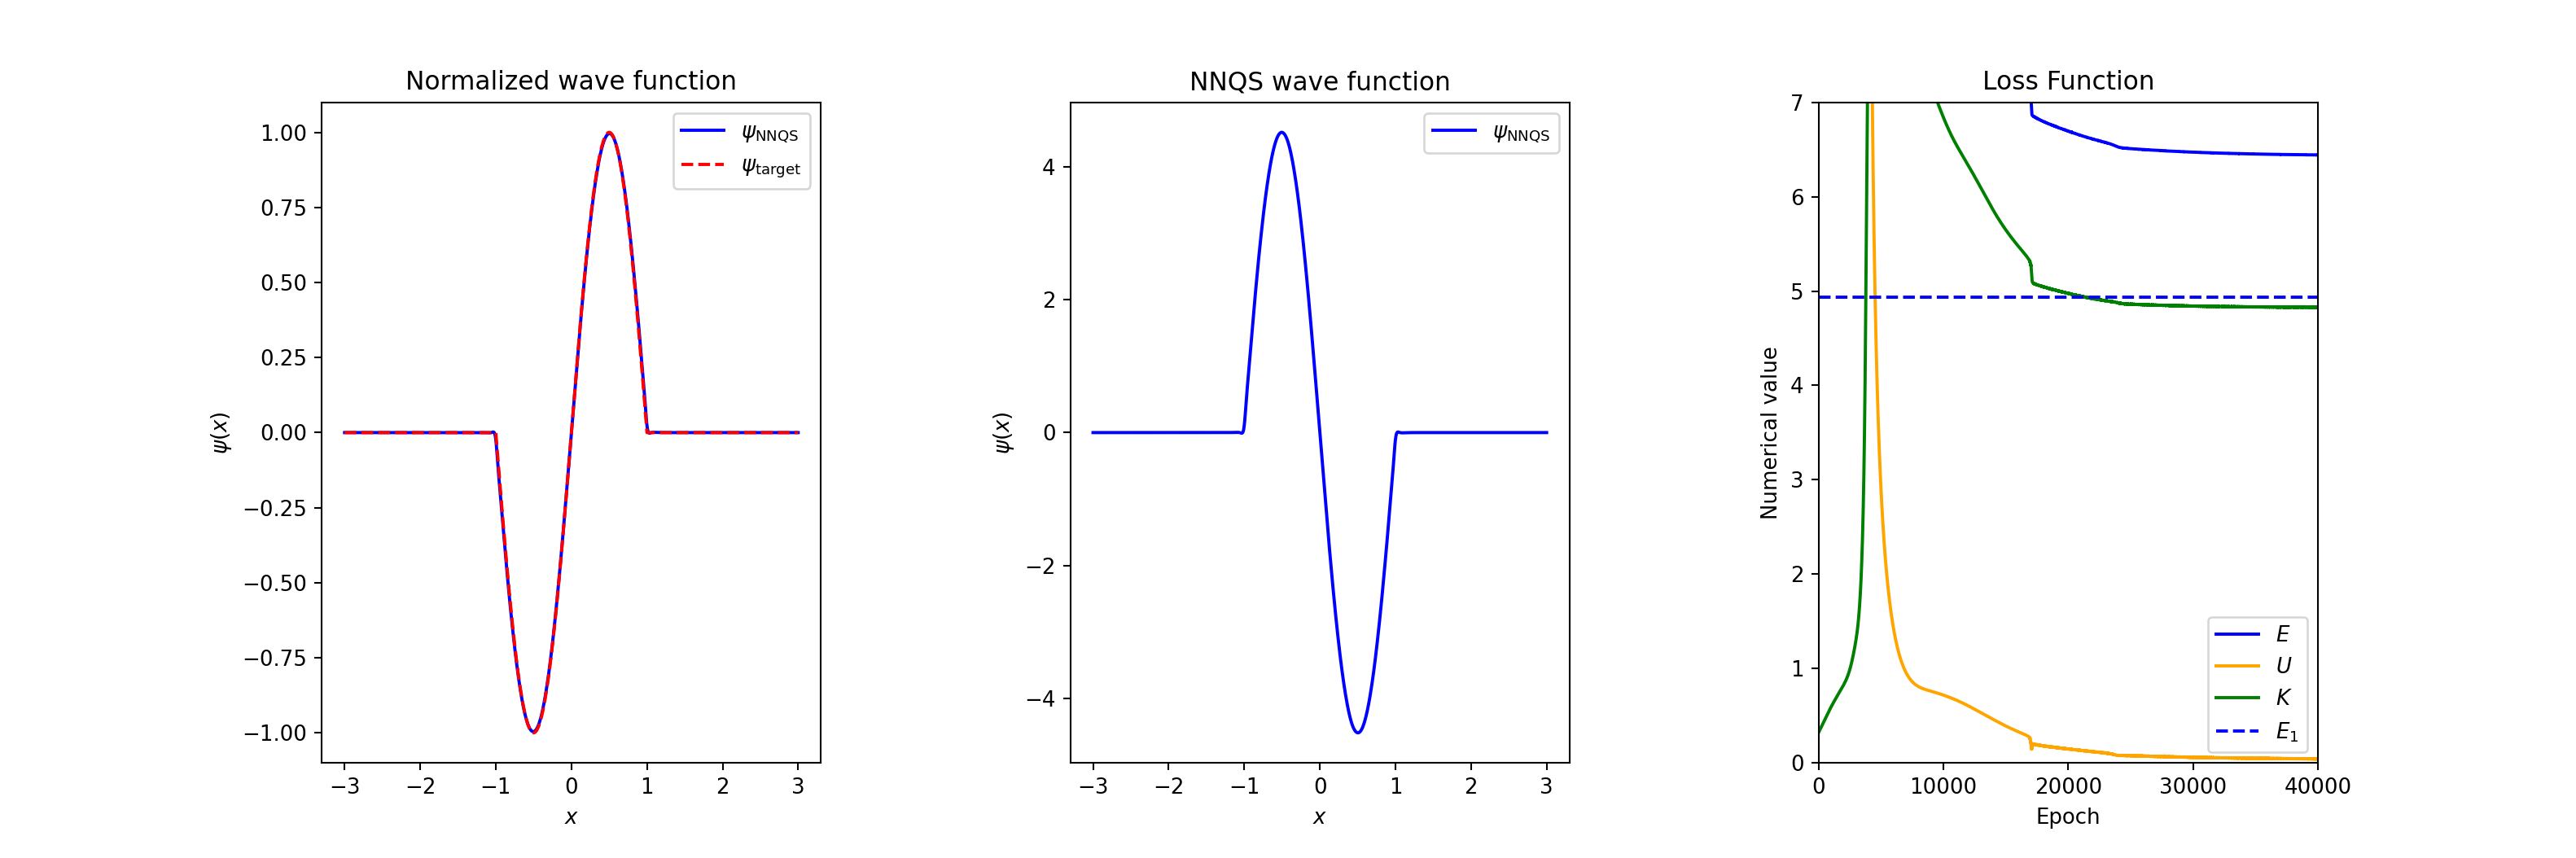

Training the NNQS...: 100%|█████████████████████████████████████████████████████| 40000/40000 [03:42<00:00, 179.40it/s]


In [12]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Numerical value")
ax3.set_ylim(0, 7)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)

# Training
loss1, U, K, psi, psi_normalized = loss_fn_prime(E0, psi0)    # Energy and \psi calculation
for i in tqdm(range(epochs), desc="Training the NNQS..."):
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss1.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss1, U, K, psi, psi_normalized = loss_fn_prime(E0, psi0)    # Energy and \psi calculation
    
    loss_accum.append(loss1.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)
        
E1, psi1 = loss_accum[-1], psi